# Network retrainings

Ok, so PF didn't send me a lot of jets, so there are a few ways that I could think to work around this

1. If I *reprocess*, I can use less jets in the test set, and this could give me a slightly larger training set. (I'll probably want to do this no matter what.)
2. I could use *all* the jets for training, instead of just the two leading ones
3. I could use some pre-trained models (but I think I should start from DIPS models) for a PFlow ext Z' or hybrid training.
4. Maybe I should see how much I gain from retraining versus just evaluating the current tagger on these new track collections.


In [1]:
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec

import numpy as np
import pandas as pd
import xarray as xr

import os
import sys
import h5py
sys.path.append("../..")
from root_to_np import getdR, passJet
from usefulFcts import VR, ftag_cone, getTrkMask, strToList, nJetsTag
from trainNet import DIPS, myLSTM
from plottingFcts import trainingMetrics, sigBkgEff, getEffs, plotROCRatio, plotROC, plotPtDependence

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Step 1: Evaluate on a couple of the taggers from the retraining campaign

In [2]:
nTrks = 60
dataDir = '../../data'
figDir = '../../figures'
baseSubDir = 'mu40_Topo_Zprime_5TeV_2lead_'

df_tag = '200ktest_{}trks_sd0_rev'.format(nTrks)

vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTagTest = '200ktest_{}trks_{}_sd0_rev'.format(nTrks,vStr)

nFeatures = 13
Ntrain = int(5e6)
nTrksTrain = 15

In [3]:
trkTags = ['PT','NT']
pts = {key : None for key in trkTags}

leffs, ceffs, beffs, = [],[],[]
discs, labels = [],[]
ys, pts, etas = [],[],[]

for tag,trkType in zip(trkTags,['pseudo','normal']):

    subDir = baseSubDir + tag
    jdf = pd.read_hdf('{}/{}/jet_{}.h5'.format(dataDir,subDir,df_tag), key='jet_df')
    
    
    for trainPhysicsSample, trainPhysTag, nHidden in zip(['hybrid_5TeV','Zprime_5TeV'],['hyb','Z\''],[400,200]):
    
        # Load in the Xs,etc
        scale_tag = '_PFlow_{}_scale'.format(trainPhysicsSample)
        f_name = "{}/{}/data_{}{}.hdf5".format(dataDir,subDir,dataTagTest,scale_tag)
        f = h5py.File(f_name,"r")

        X = f['X_test'][:]
        y = f['y_test'][:]
        ix = f['ix_test'][:]

        f.close()
    
        
        # Models
        modelDir = "../../models/mc16d_PFlow_"+trainPhysicsSample
        dataTagTrain = "{}train_{}trks_{}_sd0_rev".format(nJetsTag(Ntrain),nTrksTrain,vStr)
        m_tr = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, loadModel=True)

        # Use the weights from the model that I trained to get a new model which can process
        # all 60 of the tracks that I want to look at
        m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, timeSteps=nTrks)
        
        for layer, name in zip(m_tr.model.layers,['','','LSTM','','Dense','Jet_class']):
            if len(name) > 0:
                m.model.get_layer(name).set_weights(layer.get_weights())
        
                
        tag = '_eval_Topo_Zprime_5TeV_'+tag
        (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True, figDir=figDir,
                                          subDir=subDir,modelDir=modelDir,tag=tag)

        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)
        
        discs.append(d)
        labels.append('train PFlow ext {}, eval Topo ext Z\' w/ {} trks'.format(trainPhysTag,trkType))
        
        ys.append(y)
        pts.append(jdf.pt.values)
        etas.append(jdf.eta.values)
        

Initialize method from myModel()
Loading previously trained LSTM
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Initialize method from myModel()
Building the baseline LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Initialize method from myModel()
Building the baseline LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Initialize method from myModel()
Building the baseline LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Initialize method from myModel()
Building the baseline LSTM
Load in the previously saved efficiency file


**Thoughts:**

- I'm finding it super interesting that these PFlow trained models have this double peaked structure in the discriminant. When I saw this in my discriminants before, I thought it was because my model hadn't converged, but now I'm not sure...


../../plottingFcts.py:616: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


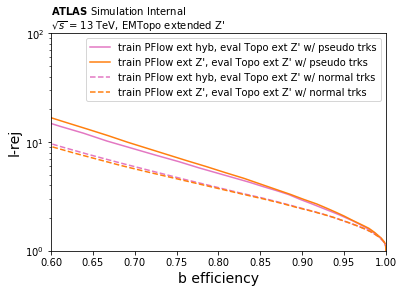

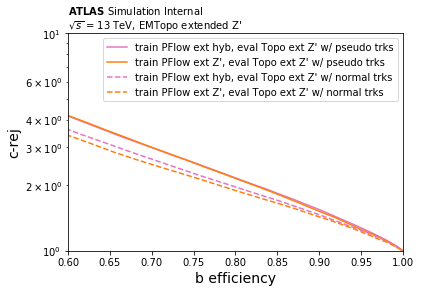

In [4]:
colors = ['C6','C1']*2
styles = ['-']*2 + ['--']*2

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, EMTopo extended Z'"

plotROC(beffs,leffs,labels,styles=styles,colors=colors,ylabel='l-rej',ymax=100,text=text)
plotROC(beffs,ceffs,labels,styles=styles,colors=colors,ylabel='c-rej',ymax=10,text=text)

**Note:** I'll have to do some kind of retraining to account for the differences in the jet collections, because none of the models from PF are performing as well as the PFlow evaluated models that I showed.

## Step 2: Try evaluating on some of my DIPS models trained on just the data from PF

In [5]:
# PT
subDir_PT = baseSubDir + 'PT'

f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir_PT,dataTagTest)
f = h5py.File(f_name,"r")

X_PT = f['X_test'][:]
y_PT = f['y_test'][:]
ix_PT = f['ix_test'][:]

f.close()

# NT
subDir_NT = baseSubDir + 'NT'

f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir_NT,dataTagTest)
f = h5py.File(f_name,"r")

X_NT = f['X_test'][:]
y_NT = f['y_test'][:]
ix_NT = f['ix_test'][:]

f.close()

In [6]:
dense_sizes = [100] * 3
ppm_sizes = [100,100,128]

Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_NT/DIPS_phi_100_100_128_F_100_100_100_3out_200ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


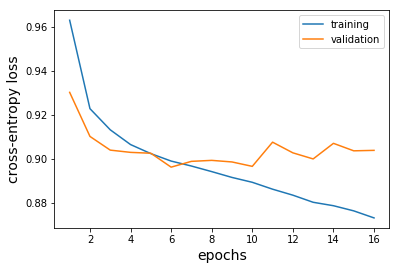

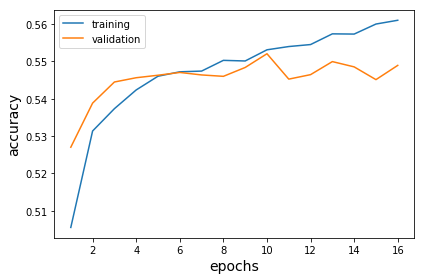

Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_PT/DIPS_phi_100_100_128_F_100_100_100_3out_200ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


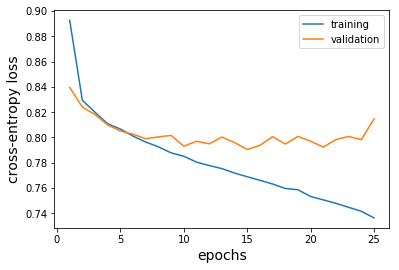

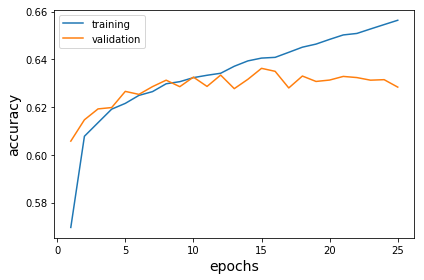

Load in the previously saved efficiency file


In [7]:
dips_leffs, dips_ceffs, dips_beffs, dips_discs = [],[],[], []

for X, y, ix, tag in zip([X_NT,X_PT], [y_NT,y_PT], [ix_NT,ix_PT], ['NT','PT']):

    subDir = 'mu40_Topo_Zprime_5TeV_2lead_'+tag
    modelDir = '../../models/'+subDir
    
    _, nTrks, nFeatures = X.shape
    
    dataTagTrain = '200ktrain_{}trks_{}_sd0_rev'.format(nTrks,vStr)
    m = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
             modelDir=modelDir, dataTag=dataTagTrain[:-8], nClasses=3, loadModel=True)
    trainingMetrics(m.modelName, modelDir)
    (leff, ceff, beff), d = getEffs(m, X, y, ix, figDir=figDir, 
                                  subDir=subDir,modelDir=modelDir, returnDisc=True)

    dips_leffs.append(leff)
    dips_ceffs.append(ceff)
    dips_beffs.append(beff)
    dips_discs.append(d)

Error: Requested binomialErrors, but did not pass nTest. Will NOT plot rej errors.


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


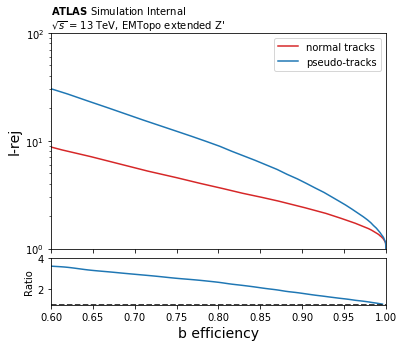

Error: Requested binomialErrors, but did not pass nTest. Will NOT plot rej errors.


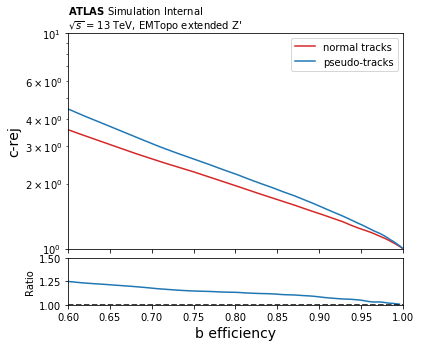

In [8]:
dips_labels = ['normal tracks','pseudo-tracks']
colors = ['C3','C0']

nTest = []

plotROCRatio(dips_beffs, dips_leffs, dips_labels, rrange=(1,4),text=text,
             ylabel='l-rej',binomialErrors=True,#nTest=nTest,
             colors=colors,ymax=100,
             figDir=figDir,subDir=subDir,tag='l-default_dips')

plotROCRatio(dips_beffs, dips_ceffs, dips_labels, rrange=(1,1.5),text=text,
             ylabel='c-rej',binomialErrors=True,#nTest=nTest,
             colors=colors,ymax=10,
             figDir=figDir,subDir=subDir,tag='c-default_dips')

Ok, so the retraining on the PT sample is giving *better* performance than I was seeing before, but the NT trainings are not doing as well.

*So...* if I think cleverly about how to solve the optimization probelem w/o that much data, I believe I can push the performance of *both* of these models.

I would really like the red curves here to be the same as the same as my PFlow ext Z' performance, but I think I can get there!!


In [9]:
pts = []

df_tag = '200ktest_{}trks_sd0_rev'.format(nTrks)

for tag in ['NT','PT']:

    subDir = 'mu40_Topo_Zprime_5TeV_2lead_'+tag
    jdf = pd.read_hdf('{}/{}/jet_{}.h5'.format(dataDir,subDir,df_tag), key='jet_df')
    pts.append(jdf.pt)

l (0, 75)
c (0, 10)
b (0, 1)


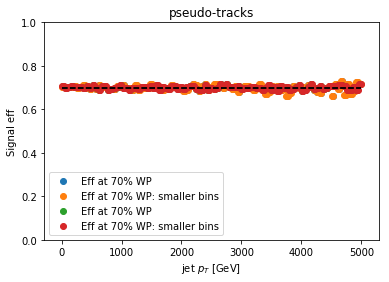

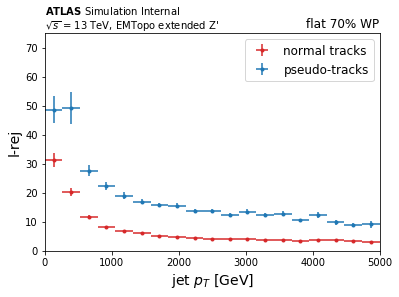

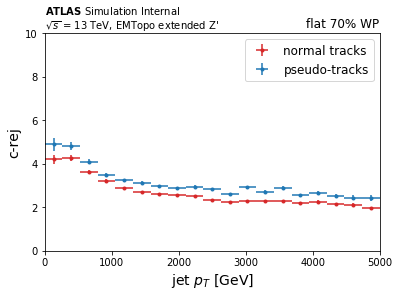

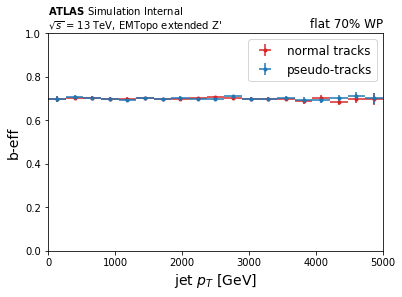

In [10]:
ptmin = 0
ptmax=5000

plotPtDependence(pts,[y_NT,y_PT],dips_discs,dips_labels,
                 lrej_lim=(0,75),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins=np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag='default_dips',verbose=False)

l (0, 50)
c (0, 10)
b (0, 1)


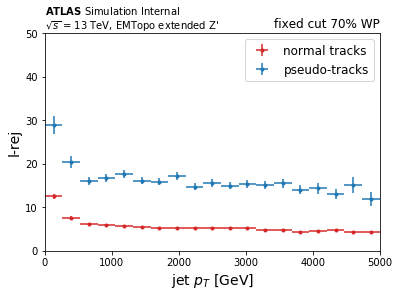

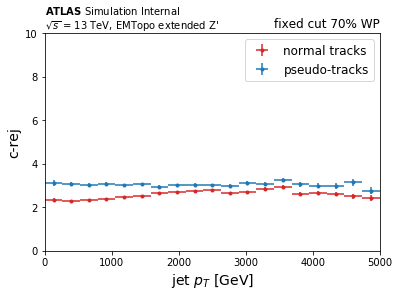

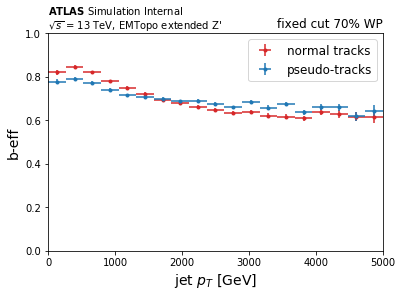

In [11]:
plotPtDependence(pts,[y_NT,y_PT],dips_discs,dips_labels,
                 lrej_lim=(0,50),crej_lim=(0,10),beff_lim=(0,1),
                 flat=False,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins=np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag='default_dips',verbose=False)

## Step 3: Retrain DIPS starting from pretrained PFlow extended Z' weights 

**Idea:** Maybe I can get better use with the data that I have if I don't have to start over from scratch.

But... since I now <3 DIPS, I'm going to redo this ext Z' training with DIPS.

Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_Zprime_5TeV/DIPS_phi_100_100_128_F_100_100_100_3out_5mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


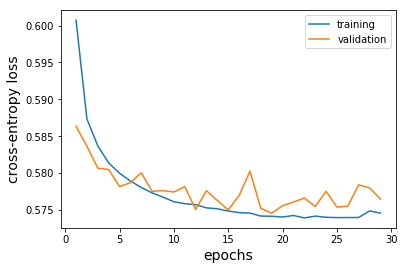

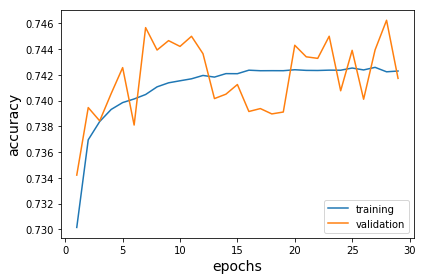

Load in the previously saved efficiency file


In [12]:
subDir = 'mc16d_PFlow_Zprime_5TeV'
modelDir = '../../models/'+subDir

_, nTrks, nFeatures = X.shape

dataTagTrain = '5mtrain_15trks_{}_sd0_rev'.format(vStr)
m = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
         modelDir=modelDir, dataTag=dataTagTrain[:-8], nClasses=3, loadModel=True)
trainingMetrics(m.modelName, modelDir)
(leff, ceff, beff), d = getEffs(m, X_NT, y_NT, ix_NT, figDir=figDir, 
                                subDir=subDir,modelDir=modelDir, returnDisc=True)

dips_leffs.append(leff)
dips_ceffs.append(ceff)
dips_beffs.append(beff)
dips_discs.append(d)

Error: Requested binomialErrors, but did not pass nTest. Will NOT plot rej errors.


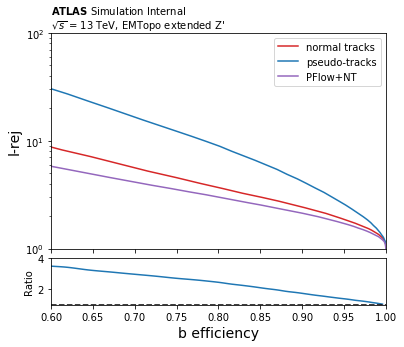

Error: Requested binomialErrors, but did not pass nTest. Will NOT plot rej errors.


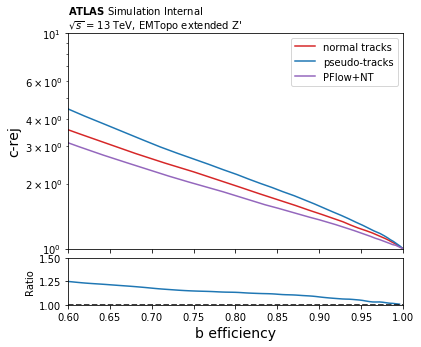

In [13]:
dips_labels = ['normal tracks','pseudo-tracks','PFlow+NT']
colors = ['C3','C0','C4']

nTest = []

plotROCRatio(dips_beffs, dips_leffs, dips_labels, rrange=(1,4),text=text,
             ylabel='l-rej',binomialErrors=True,#nTest=nTest,
             colors=colors,ymax=100)#,
             #figDir=figDir,subDir=subDir,tag='l-default_dips')

plotROCRatio(dips_beffs, dips_ceffs, dips_labels, rrange=(1,1.5),text=text,
             ylabel='c-rej',binomialErrors=True,#nTest=nTest,
             colors=colors,ymax=10)#,
             #figDir=figDir,subDir=subDir,tag='c-default_dips')

There is some gain in the dedicated DIPS retraining for PFlow, but not by a lot.

- Also, the NT performance is now comparable (actually, a bit above) the performance from the PFflow Z'RNN training evaluated on NT, so it looks like this DIPS architecture is complex enough to provide some first answers!!

- This is great news, b/c it means I don't have to retrain the RNN (phew)!

**What does this mean?**

- So, the difference in the performance plots for extended Z' must have come from the choice of only selecting the two leading jets... I think this makes a lot of sense when I compare VR and PFlow performance plots (since I introduced this 2 leading cut for my VR evaluation).

*Let's test this out before implementing the next steps!*


In [14]:
dataTagTest

'200ktest_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev'

In [15]:
df_tag

'200ktest_60trks_sd0_rev'

In [16]:
# PT
subDir_PT = 'mu40_Topo_Zprime_5TeV_PT'

f_name = "{}/{}/data_5{}_Zprime_5TeV_2lead_PT_scale.hdf5".format(dataDir,subDir_PT,dataTagTest[1:])
f = h5py.File(f_name,"r")

X_all_PT = f['X_test'][:]
y_all_PT = f['y_test'][:]
ix_all_PT = f['ix_test'][:]

f.close()

jdf = pd.read_hdf('{}/{}/jet_5{}.h5'.format(dataDir,subDir_PT,df_tag[1:]), key='jet_df')
jpt_all_PT = jdf.pt.values
    

# NT
subDir_NT = 'mu40_Topo_Zprime_5TeV_NT'

f_name = "{}/{}/data_5{}_Zprime_5TeV_2lead_NT_scale.hdf5".format(dataDir,subDir_NT,dataTagTest[1:])
f = h5py.File(f_name,"r")

X_all_NT = f['X_test'][:]
y_all_NT = f['y_test'][:]
ix_all_NT = f['ix_test'][:]

jdf = pd.read_hdf('{}/{}/jet_5{}.h5'.format(dataDir,subDir_NT,df_tag[1:]), key='jet_df')
jpt_all_NT = jdf.pt.values

f.close()

Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_NT/DIPS_phi_100_100_128_F_100_100_100_3out_200ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


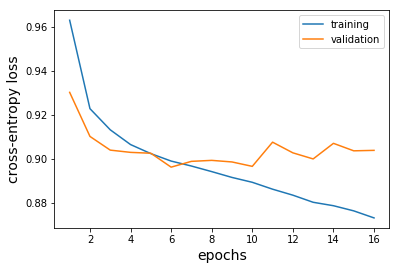

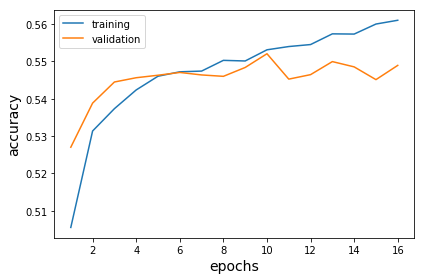

Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_PT/DIPS_phi_100_100_128_F_100_100_100_3out_200ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


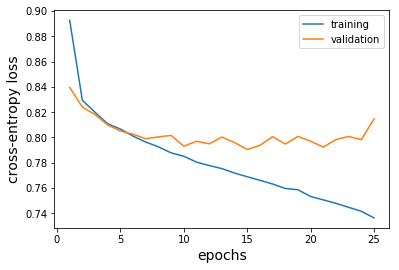

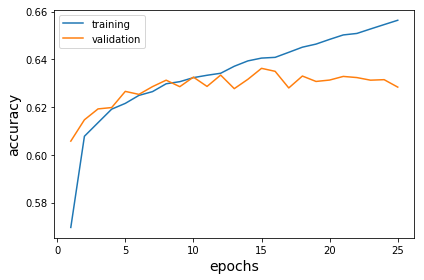

Load in the previously saved efficiency file


In [17]:
for X, y, ix, tag in zip([X_all_NT,X_all_PT], [y_all_NT,y_all_PT], [ix_all_NT,ix_all_PT], ['NT','PT']):

    subDir = 'mu40_Topo_Zprime_5TeV_2lead_'+tag
    modelDir = '../../models/'+subDir
    
    _, nTrks, nFeatures = X.shape
    
    dataTagTrain = '200ktrain_{}trks_{}_sd0_rev'.format(nTrks,vStr)
    m = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
             modelDir=modelDir, dataTag=dataTagTrain[:-8], nClasses=3, loadModel=True)
    trainingMetrics(m.modelName, modelDir)
    (leff, ceff, beff), d = getEffs(m, X, y, ix, figDir=figDir, subDir=subDir,modelDir=modelDir, 
                                    returnDisc=True,tag='_inclusiveJets')

    dips_leffs.append(leff)
    dips_ceffs.append(ceff)
    dips_beffs.append(beff)
    dips_discs.append(d)

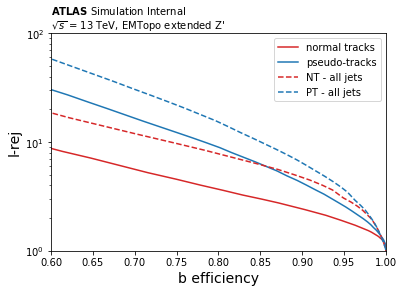

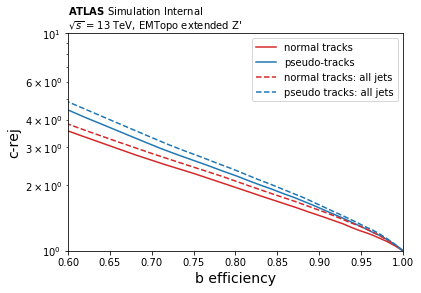

In [18]:
plotROC(dips_beffs[:2]+dips_beffs[-2:],
        dips_leffs[:2]+dips_leffs[-2:],
        dips_labels[:2]+['NT - all jets','PT - all jets'],
        ylabel='l-rej',colors=['C3','C0']*2,styles=['-']*2+['--']*2,
        ymax=100, text=text)

plotROC(dips_beffs[:2]+dips_beffs[-2:],
        dips_ceffs[:2]+dips_ceffs[-2:],
        dips_labels[:2]+['normal tracks: all jets','pseudo tracks: all jets'],
        ylabel='c-rej',colors=['C3','C0']*2,styles=['-']*2+['--']*2,
        ymax=10, text=text)

Interesting.... I'm seeing a lot *bigger* drop in performance for the extended Z' than I remember seeing for the standard Z' when I was looking into this with VR.

I guess this makes sense, but also, good to follow up on!!

Just to close the loop, I want to look into the $p_T$ performance plots too.

i_eff = 114, teff = 0.7014925373134324
Cut on discriminant at -0.1470423221588124
i_eff = 104, teff = 0.7030567685589518
Cut on discriminant at 0.9302402973175052
i_eff = 101, teff = 0.701550387596899
Cut on discriminant at 1.2534250831604012
i_eff = 98, teff = 0.7043189368770763
Cut on discriminant at 1.5766098690032955
i_eff = 96, teff = 0.7060702875399356
Cut on discriminant at 1.79206639289856
i_eff = 99, teff = 0.697560975609756
Cut on discriminant at 1.468881607055664
i_eff = 102, teff = 0.7013274336283184
Cut on discriminant at 1.145696821212768
i_eff = 101, teff = 0.7107438016528929
Cut on discriminant at 1.2534250831604012
i_eff = 102, teff = 0.6987060998151567
Cut on discriminant at 1.145696821212768
i_eff = 105, teff = 0.6951219512195126
Cut on discriminant at 0.8225120353698738
i_eff = 108, teff = 0.7046875000000001
Cut on discriminant at 0.4993272495269778
i_eff = 104, teff = 0.694063926940639
Cut on discriminant at 0.9302402973175052
i_eff = 105, teff = 0.7112375533428165

99
(99,)
0.7
l (0, 50)
0.7
c (0, 10)
0.7
b (0, 1)


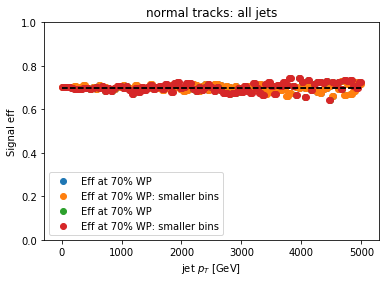

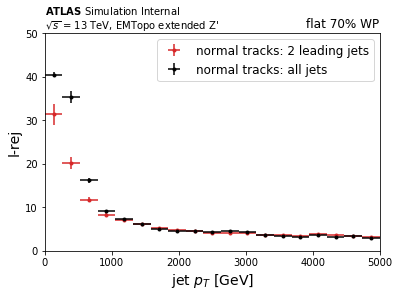

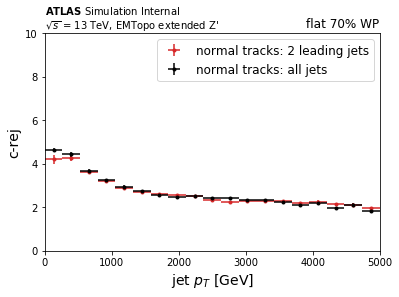

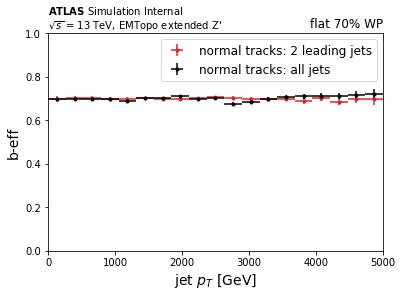

In [19]:
plotPtDependence([pts[0],jpt_all_NT],[y_NT,y_all_NT],
                 [dips_discs[0],dips_discs[-2]],
                 ['normal tracks: 2 leading jets','normal tracks: all jets'],
                 lrej_lim=(0,50),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=['C3','k'],text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins=np.linspace(ptmin,ptmax,100))#,
                 #figDir=figDir,subDir=subDir,tag='NT_2lead_vs_inclusive',verbose=False)

i_eff = 102, teff = 0.7058823529411768
Cut on discriminant at 0.5808626222610478
i_eff = 97, teff = 0.6986899563318771
Cut on discriminant at 1.2758812236785886
i_eff = 97, teff = 0.7015503875968989
Cut on discriminant at 1.2758812236785886
i_eff = 93, teff = 0.7076411960132891
Cut on discriminant at 1.8318961048126212
i_eff = 91, teff = 0.7038216560509554
Cut on discriminant at 2.1099035453796375
i_eff = 94, teff = 0.702439024390244
Cut on discriminant at 1.692892384529113
i_eff = 95, teff = 0.7013274336283184
Cut on discriminant at 1.553888664245605
i_eff = 93, teff = 0.6983471074380164
Cut on discriminant at 1.8318961048126212
i_eff = 96, teff = 0.7060998151571167
Cut on discriminant at 1.4148849439620967
i_eff = 95, teff = 0.6986062717770032
Cut on discriminant at 1.553888664245605
i_eff = 100, teff = 0.7140625000000002
Cut on discriminant at 0.8588700628280641
i_eff = 96, teff = 0.700152207001522
Cut on discriminant at 1.4148849439620967
i_eff = 95, teff = 0.689900426742532
Cut on

99
(99,)
0.7
l (0, 200)
0.7
c (0, 10)
0.7
b (0, 1)


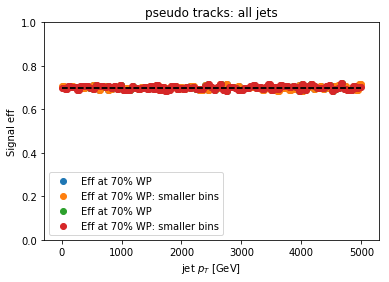

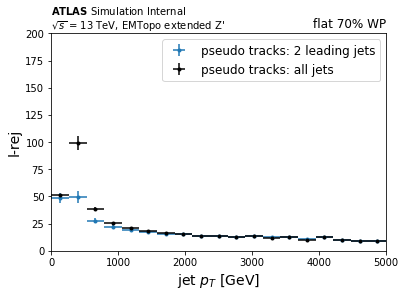

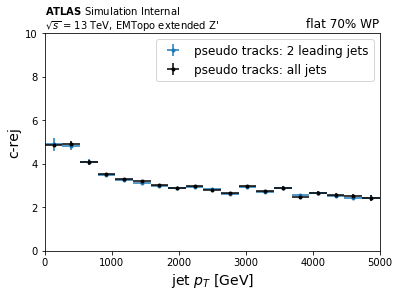

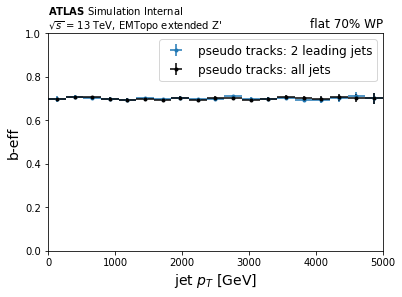

In [20]:
plotPtDependence([pts[1],jpt_all_PT],[y_PT,y_all_PT],
                 [dips_discs[1],dips_discs[-1]],
                 ['pseudo tracks: 2 leading jets','pseudo tracks: all jets'],
                 lrej_lim=(0,200),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=['C0','k'],text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins=np.linspace(ptmin,ptmax,100))#,
                 #figDir=figDir,subDir=subDir,tag='NT_2lead_vs_inclusive',verbose=False)

Ok, I think the last check that I would need to do would to be to compare the Z' performance on the leading two jets and on all of the jets.

I don't know if I'll have time to do this by tonight, but I submitted the jobs that process this in parallel, so I can do this check later (if desired)

# Using pre-trained weights

Ok, so I think I can gain by just fine-tuning a training instead of starting over from scratch, so *let's test this hypothesis!*

In [21]:
dataTagTest

'200ktest_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev'

Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_NT/DIPS_phi_100_100_128_F_100_100_100_3out_200ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_pretrained_weights_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


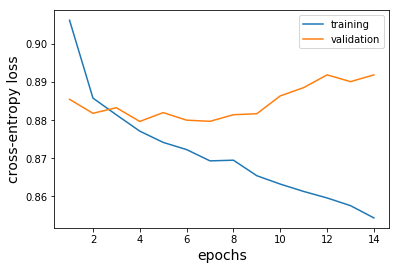

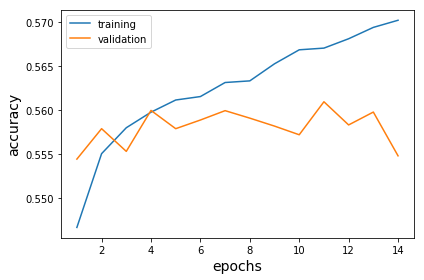

Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_PT/DIPS_phi_100_100_128_F_100_100_100_3out_200ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_pretrained_weights_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


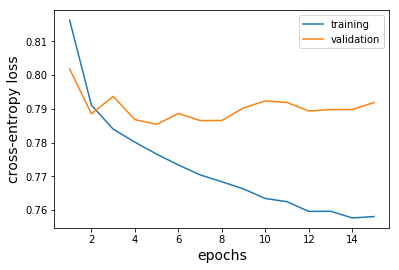

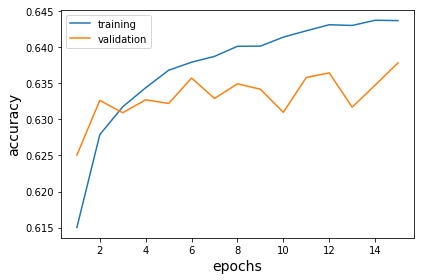

Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_sctSplit/DIPS_phi_100_100_128_F_100_100_100_3out_200ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_pretrained_weights_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


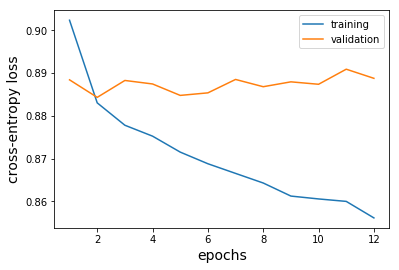

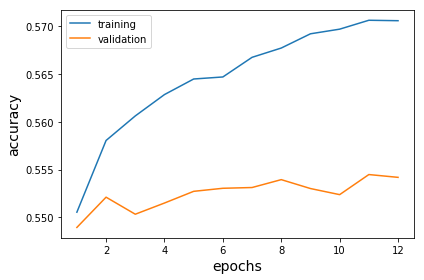

Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_Bcut/DIPS_phi_100_100_128_F_100_100_100_3out_100ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_pretrained_weights_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


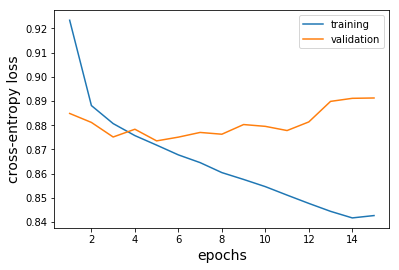

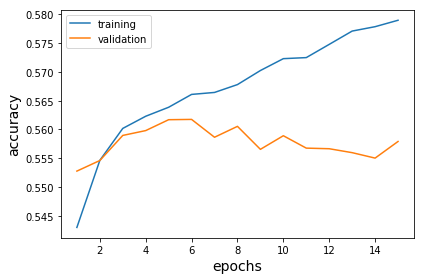

Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_BcutRefit/DIPS_phi_100_100_128_F_100_100_100_3out_70ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_pretrained_weights_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


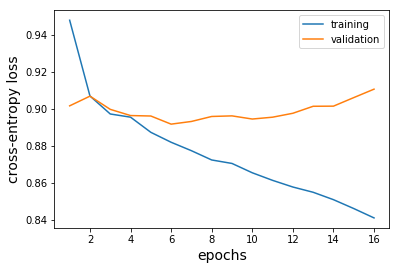

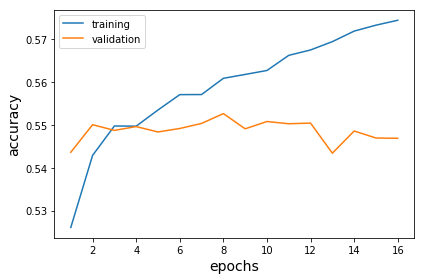

../../plottingFcts.py:138: RuntimeWarning: divide by zero encountered in log
  disc = np.log(np.divide(predictions[:,2], fc*predictions[:,1] + (1 - fc) * predictions[:,0]))


36 jets had a negative inf disc
min: -85.31, max: 14.34


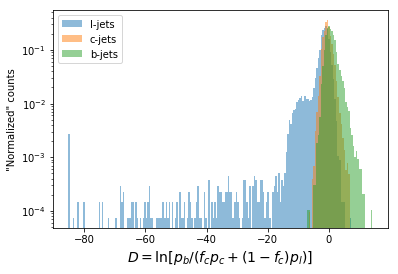

In [36]:
pre_leffs, pre_ceffs, pre_beffs = [],[],[]
pre_discs, pre_pts, pre_ys = [],[],[]

for tag, nJetsTag in zip(['NT','PT','sctSplit','Bcut','BcutRefit'],['200k','200k','200k','100k','70k']):

    subDir = 'mu40_Topo_Zprime_5TeV_2lead_'+tag
    
    '''
    Retrieve the data
    '''
    # Load in the Xs,etc
    
    f_name = "{}/{}/data_{}{}.hdf5".format(dataDir,subDir,nJetsTag,dataTagTest[4:])
    f = h5py.File(f_name,"r")

    X = f['X_test'][:]
    y = f['y_test'][:]
    ix = f['ix_test'][:]

    f.close()
    
    jdf = pd.read_hdf('{}/{}/jet_{}{}.h5'.format(dataDir,subDir,nJetsTag,df_tag[4:]), key='jet_df')
    pre_ys.append(y)
    pre_pts.append(jdf.pt.values)
    
    modelDir = '../../models/'+subDir
    _, nTrks, nFeatures = X.shape
    
    dataTagTrain = '{}train_{}trks_{}_sd0_rev'.format(nJetsTag,nTrks,vStr)
    m = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
             modelDir=modelDir, dataTag=dataTagTrain[:-8], nClasses=3, loadModel=True,
             modelTag='_pretrained_weights')
    trainingMetrics(m.modelName, modelDir)
    
    (leff, ceff, beff), d = getEffs(m, X, y, ix, figDir=figDir, 
                                      subDir=subDir,modelDir=modelDir, returnDisc=True)

    pre_leffs.append(leff)
    pre_ceffs.append(ceff)
    pre_beffs.append(beff)
    pre_discs.append(d)


In [37]:
len(pre_beffs)

5

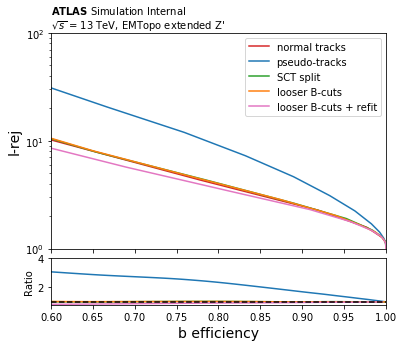

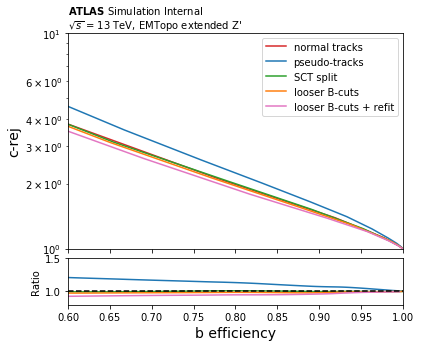

In [39]:
pre_labels = ['normal tracks','pseudo-tracks','SCT split','looser B-cuts','looser B-cuts + refit']
pre_colors = ['C3','C0','C2','C1','C6']

nTest = []

plotROCRatio(pre_beffs, pre_leffs, pre_labels, rrange=(0.8,4),text=text,
             ylabel='l-rej',#binomialErrors=True,#nTest=nTest,
             colors=pre_colors,ymax=100,figDir=figDir,subDir=subDir,tag='l-pretrainedWeights')

plotROCRatio(pre_beffs, pre_ceffs, pre_labels, rrange=(0.8,1.5),text=text,
             ylabel='c-rej',#binomialErrors=True,#nTest=nTest,
             colors=pre_colors,ymax=10,figDir=figDir,subDir=subDir,tag='c-pretrainedWeights')

Oh... this is sad. This retraining w/ pretrained weights did not help *at all*.

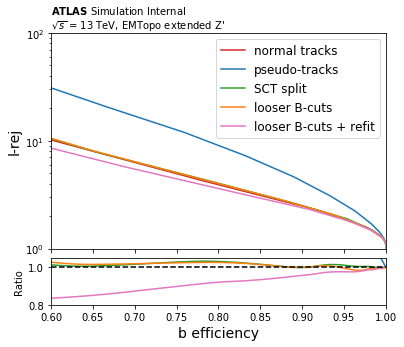

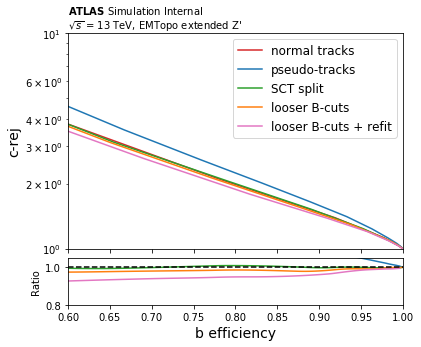

In [46]:
plotROCRatio(pre_beffs, pre_leffs, pre_labels, rrange=(0.8,1.05),text=text,
             ylabel='l-rej',legFontSize=12,#binomialErrors=True,#nTest=nTest,
             colors=pre_colors,ymax=100,figDir=figDir,subDir=subDir,
             tag='l-pretrainedWeights-Zoom')

plotROCRatio(pre_beffs, pre_ceffs, pre_labels, rrange=(0.8,1.05),text=text,
             ylabel='c-rej',legFontSize=12,#binomialErrors=True,#nTest=nTest,
             colors=pre_colors,ymax=10,figDir=figDir,subDir=subDir,
             tag='c-pretrainedWeights-Zoom')

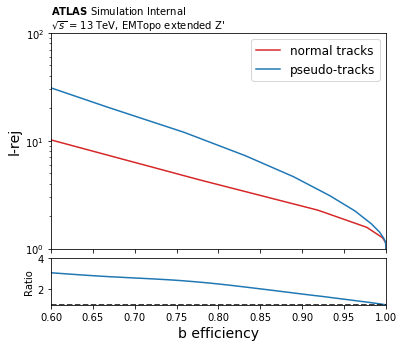

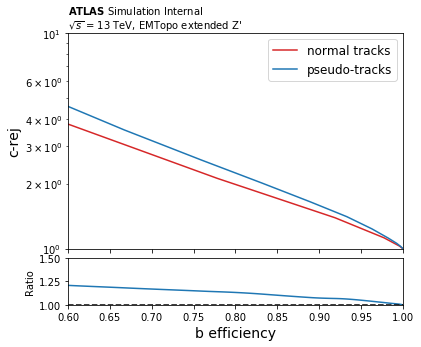

In [26]:
plotROCRatio(pre_beffs[:2], pre_leffs[:2], pre_labels, rrange=(1,4),text=text,
             ylabel='l-rej',legFontSize=12,#binomialErrors=True,#nTest=nTest,
             colors=pre_colors,ymax=100,figDir=figDir,subDir=subDir[:-4]+"PT",tag='l-pretrainedWeights')

plotROCRatio(pre_beffs[:2], pre_ceffs[:2], pre_labels, rrange=(1,1.5),text=text,
             ylabel='c-rej',legFontSize=12,#binomialErrors=True,#nTest=nTest,
             colors=pre_colors,ymax=10,figDir=figDir,subDir=subDir[:-4]+"PT",tag='c-pretrainedWeights')

l (0, 100)
c (0, 10)
b (0, 1)


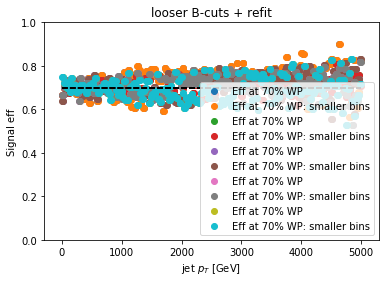

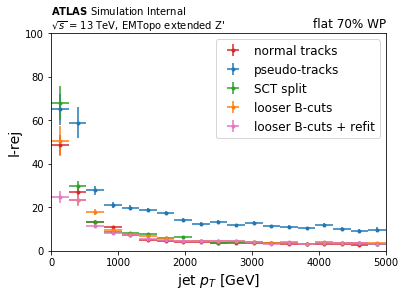

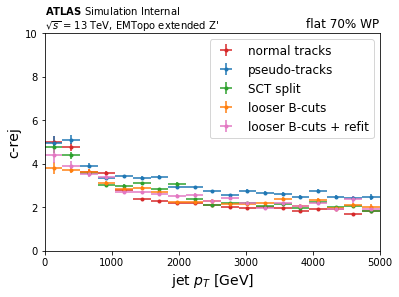

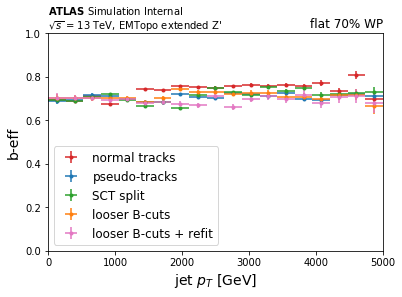

In [47]:
plotPtDependence(pre_pts,pre_ys,pre_discs,pre_labels,
                 lrej_lim=(0,100),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=pre_colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins=np.linspace(ptmin,ptmax,200),
                 figDir=figDir,subDir=subDir,tag='pretrainedWeights',verbose=False)

l (0, 100)
c (0, 10)
b (0, 1)


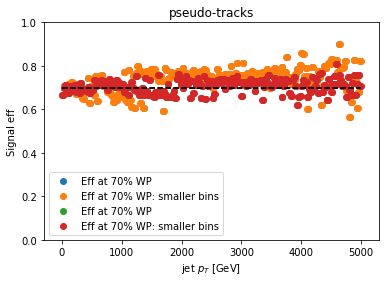

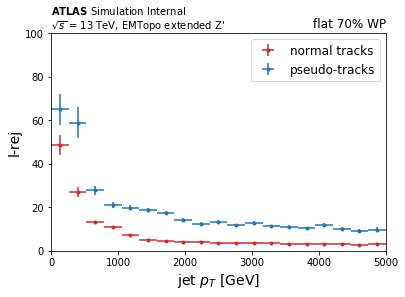

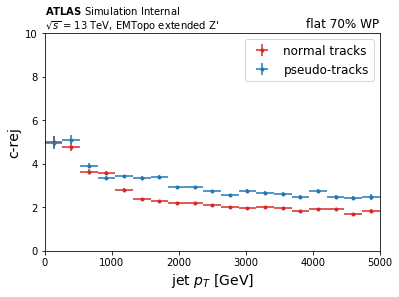

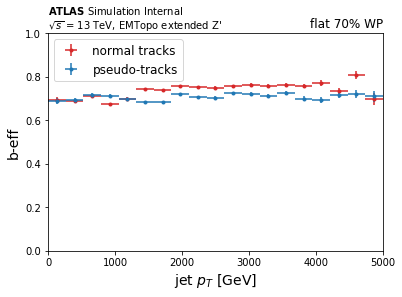

In [29]:
plotPtDependence(pre_pts[:2],pre_ys[:2],pre_discs,pre_labels,
                 lrej_lim=(0,100),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=pre_colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins=np.linspace(ptmin,ptmax,200),
                 figDir=figDir,subDir=subDir[:-4]+"PT",tag='pretrainedWeights',verbose=False)

**Thoughts:**
- I don't think 70k is enough stats, because it doesn't make sense why the performance would be so much worse for this version of the tagger.

*Let's characterize this discrepancy w/ NT.*

Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_PT/DIPS_phi_100_100_128_F_100_100_100_3out_70ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_pretrained_weights_weights.h5
Loading previously trained DIPS weight file
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_PT/DIPS_phi_100_100_128_F_100_100_100_3out_100ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_pretrained_weights_weights.h5
Loading previously trained DIPS weight file
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_PT/DIPS_phi_100_100_128_F_100_100_100_3out_200ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedB

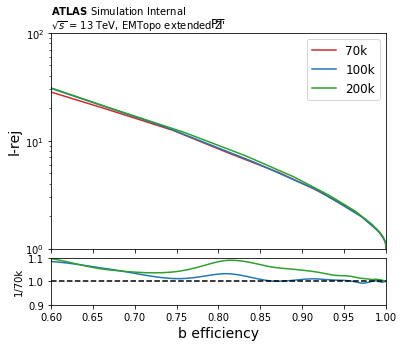

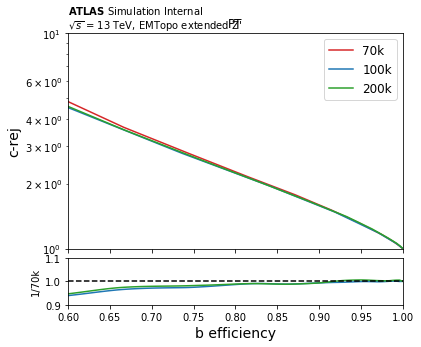

Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_NT/DIPS_phi_100_100_128_F_100_100_100_3out_70ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_pretrained_weights_weights.h5
Loading previously trained DIPS weight file
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_NT/DIPS_phi_100_100_128_F_100_100_100_3out_100ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_pretrained_weights_weights.h5
Loading previously trained DIPS weight file
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_NT/DIPS_phi_100_100_128_F_100_100_100_3out_200ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedB

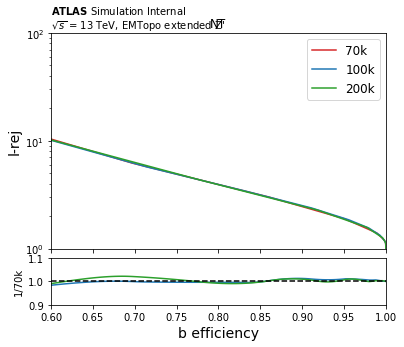

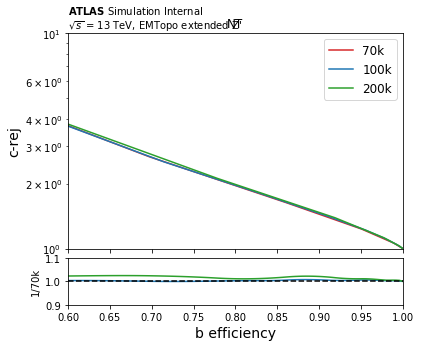

In [83]:
nJetsTags = ['70k','100k','200k']


for tag in ['PT','NT']:
    
    leffs, ceffs, beffs, discs = [],[],[],[]
    
    for nJetsTag in nJetsTags:
        
        subDir = 'mu40_Topo_Zprime_5TeV_2lead_'+tag
    
        # Load in the Xs,etc

        f_name = "{}/{}/data_{}{}.hdf5".format(dataDir,subDir,'200k',dataTagTest[4:])
        f = h5py.File(f_name,"r")

        X = f['X_test'][:]
        y = f['y_test'][:]
        ix = f['ix_test'][:]

        f.close()

        jdf = pd.read_hdf('{}/{}/jet_{}{}.h5'.format(dataDir,subDir,'200k',df_tag[4:]), key='jet_df')
        pre_ys.append(y)
        pre_pts.append(jdf.pt.values)

        modelDir = '../../models/'+subDir
        _, nTrks, nFeatures = X.shape

        dataTagTrain = '{}train_{}trks_{}_sd0_rev'.format(nJetsTag,nTrks,vStr)
        m = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
                 modelDir=modelDir, dataTag=dataTagTrain[:-8], nClasses=3, loadModel=True,
                 modelTag='_pretrained_weights')
        #trainingMetrics(m.modelName, modelDir)

        (leff, ceff, beff), d = getEffs(m, X, y, ix, figDir=figDir, 
                                        subDir=subDir,modelDir=modelDir, returnDisc=True)

        # I need to look at the
        mask = (beff > 1e-3)
        leffs.append(leff[mask])
        ceffs.append(ceff[mask])
        beffs.append(beff[mask])
        discs.append(d)
        
    plotROCRatio(beffs, leffs, nJetsTags, rrange=(0.9,1.1),text=text,#title=tag,
                 ylabel='l-rej',legFontSize=12,#binomialErrors=True,#nTest=nTest,
                 colors=pre_colors,ymax=100,rlabel='1/70k')#figDir=figDir,subDir=subDir,
                 #tag='l-pretrainedWeights-Zoom')

    plotROCRatio(beffs, ceffs, nJetsTags, rrange=(0.9,1.1),text=text,#title=tag,
                 ylabel='c-rej',legFontSize=12,#binomialErrors=True,#nTest=nTest,
                 colors=pre_colors,ymax=10,rlabel='1/70k')#,figDir=figDir,subDir=subDir,
                 #tag='c-pretrainedWeights-Zoom')

**Performance plots for 70k, 100k jets**

In [ ]:
for nJetsTrainTag in nJetsTags:

    leffs, ceffs, beffs, discs = [],[],[],[]
    
    for tag, nJetsTag in zip(['NT','PT','sctSplit','Bcut','BcutRefit'],['200k','200k','200k','100k','70k']):
        
        subDir = 'mu40_Topo_Zprime_5TeV_2lead_'+tag
    
        # Load in the Xs,etc

        f_name = "{}/{}/data_{}{}.hdf5".format(dataDir,subDir,nJetsTag,dataTagTest[4:])
        f = h5py.File(f_name,"r")

        X = f['X_test'][:]
        y = f['y_test'][:]
        ix = f['ix_test'][:]

        f.close()

        jdf = pd.read_hdf('{}/{}/jet_{}{}.h5'.format(dataDir,subDir,nJetsTag,df_tag[4:]), key='jet_df')
        pre_ys.append(y)
        pre_pts.append(jdf.pt.values)

        modelDir = '../../models/'+subDir
        _, nTrks, nFeatures = X.shape

        dataTagTrain = '{}train_{}trks_{}_sd0_rev'.format(nJetsTrainTag,nTrks,vStr)
        m = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
                 modelDir=modelDir, dataTag=dataTagTrain[:-8], nClasses=3, loadModel=True,
                 modelTag='_pretrained_weights')
        #trainingMetrics(m.modelName, modelDir)

        (leff, ceff, beff), d = getEffs(m, X, y, ix, figDir=figDir, 
                                        subDir=subDir,modelDir=modelDir, returnDisc=True)

        # I need to look at the
        #mask = (beff > 1e-3)
        leffs.append(leff)#[mask])
        ceffs.append(ceff)#[mask])
        beffs.append(beff)#[mask])
        discs.append(d)
        
    plotROCRatio(beffs, leffs, pre_labels, rrange=(0.9,1.1),text=text,#title=tag,
                 ylabel='l-rej',legFontSize=12,#binomialErrors=True,#nTest=nTest,
                 colors=pre_colors,ymax=100,rlabel='1/70k')#figDir=figDir,subDir=subDir,
                 #tag='l-pretrainedWeights-Zoom')

    plotROCRatio(beffs, ceffs, pre_labels, rrange=(0.9,1.1),text=text,#title=tag,
                 ylabel='c-rej',legFontSize=12,#binomialErrors=True,#nTest=nTest,
                 colors=pre_colors,ymax=10,rlabel='1/70k')#,figDir=figDir,subDir=subDir,
                 #tag='c-pretrainedWeights-Zoom')

Initialize method from myModel()
weightFile ../../models/mu40_Topo_Zprime_5TeV_2lead_NT/DIPS_phi_100_100_128_F_100_100_100_3out_70ktrain_60trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_pretrained_weights_weights.h5
Loading previously trained DIPS weight file
